In [21]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [22]:
# load the dataset and check for unnecessary columns
df = pd.read_csv('/Users/faris/Downloads/cust_seg.csv', index_col = 'Customer Id')
display(df.head())
display(df.info())

,Unnamed: 0,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
Customer Id,,,,,,,,,
1,0,41,2,6,19,0.124,1.073,0.0,6.3
2,1,47,1,26,100,4.582,8.218,0.0,12.8
3,2,33,2,10,57,6.111,5.802,1.0,20.9
4,3,29,2,4,19,0.681,0.516,0.0,6.3
5,4,47,1,31,253,9.308,8.908,0.0,7.2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 1 to 850
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 66.4 KB


None

# Data Inspection

In [23]:
df.drop(columns='Unnamed: 0', inplace=True)

In [24]:
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
Customer Id,,,,,,,,
1,41,2,6,19,0.124,1.073,0.0,6.3
2,47,1,26,100,4.582,8.218,0.0,12.8
3,33,2,10,57,6.111,5.802,1.0,20.9
4,29,2,4,19,0.681,0.516,0.0,6.3
5,47,1,31,253,9.308,8.908,0.0,7.2


## Checking for duplicate rows

In [25]:
# We will check for duplicate rows and delete them.
dup = df.duplicated().sum()
print(f'There are {dup} duplicate rows.')

There are 0 duplicate rows.


## Checking for outliers and obvious errors

In [26]:
df.describe()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


## Creating Total Debt feature by combining card debt and other debt columns

In [27]:
df['Total Debt'] = df['Card Debt'] + df['Other Debt']

df.drop(columns= ['Card Debt', 'Other Debt'], inplace=True)

df.head()

,Age,Edu,Years Employed,Income,Defaulted,DebtIncomeRatio,Total Debt
Customer Id,,,,,,,
1,41,2,6,19,0.0,6.3,1.197
2,47,1,26,100,0.0,12.8,12.800
3,33,2,10,57,1.0,20.9,11.913
4,29,2,4,19,0.0,6.3,1.197
5,47,1,31,253,0.0,7.2,18.216


## Checking for missing values


In [28]:
df.isna().sum()

Age                  0
Edu                  0
Years Employed       0
Income               0
Defaulted          150
DebtIncomeRatio      0
Total Debt           0
dtype: int64

There are 150 missing values in Defaulted.
- Options:
    - Dropping rows was not a good option because 17.65% of rows are missing data--too many (>2%) to just eliminate.
    - Dropping columns was not a good option because whether they defaulted might be an import property for clustering--additionally, it is one of the properties specifically requested by the company.   Also, <50% of the data are missing, too little to just eliminate.
    - Creating a new category was not a good option because it would introduce errors that might skew the clusters.
    - Imputing the most frequent value was a good option because the most frequent value is most likely the value closest to the missing values.

## Getting mode of Defaulted feature and imputing it to missing data

In [29]:
mode = df['Defaulted'].mode()
mode

0    0.0
Name: Defaulted, dtype: float64

In [30]:

df['Defaulted'].fillna(0.0, inplace=True)
df.isna().sum()

Age                0
Edu                0
Years Employed     0
Income             0
Defaulted          0
DebtIncomeRatio    0
Total Debt         0
dtype: int64

## Scaling the data

In [31]:
# Initiating standard scaler
scaler = StandardScaler()

# Fitting and transforming data
scaled_df = scaler.fit_transform(df)

## KMeans Clustering

### Elbow plot of inertia

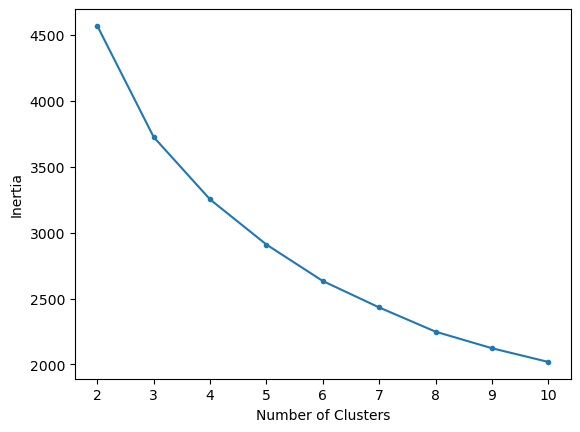

In [32]:
# Creating an empty list of inertias
inertias = []
# Looping through k values between 2 and 10 and store the inertias in the list
for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, random_state=42)
  kmeans.fit(scaled_df)
  inertias.append(kmeans.inertia_)
# Visualizing scores
plt.plot(range(2, 11), inertias, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

The inertia plot does not have a very pronounced elbow at any number, but the graph seems to level off a bit at 4 clusters. 4 would be one candidate for a good number of clusters.


## Silhouette scores

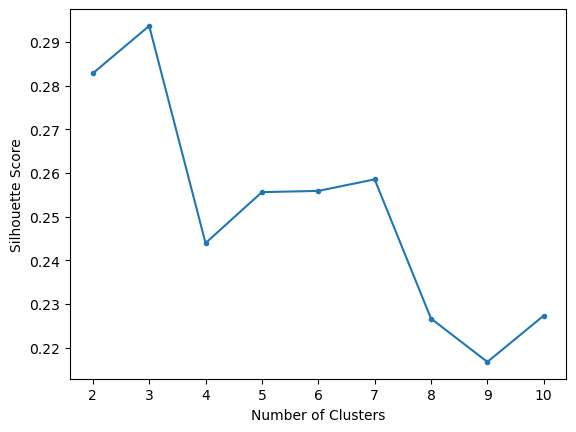

In [33]:
# Saving silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i, random_state=42)
  kmeans.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))
# Visualizing scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

- The graph shows that 3 would be another candidate for a good number of clusters since it has the highest Silhouette Score.


## Fitting 2 different KMeans models (one with 3 clusters and one with 4 clusters)

In [34]:

# instantiate two different KMeans models using 2 clusters and 4 clusters
kmeans3 = KMeans(n_clusters = 3, random_state=42)
kmeans4 = KMeans(n_clusters = 4, random_state=42)
# fit the models
kmeans3.fit(scaled_df)
kmeans4.fit(scaled_df)
# display the silhouette scores
print(f'Silhouette Score using 3 clusters: {silhouette_score(scaled_df, kmeans3.labels_).round(2)}')
print(f'Silhouette Score using 4 clusters: {silhouette_score(scaled_df, kmeans4.labels_).round(2)}')

Silhouette Score using 3 clusters: 0.29
Silhouette Score using 4 clusters: 0.24


## Saving the final KMeans Clustering Model

In [35]:
# Adding the clusters as a new column in the original unscaled data frame
df['cluster'] = kmeans3.labels_
df.head()

,Age,Edu,Years Employed,Income,Defaulted,DebtIncomeRatio,Total Debt,cluster
Customer Id,,,,,,,,
1,41,2,6,19,0.0,6.3,1.197,0
2,47,1,26,100,0.0,12.8,12.800,1
3,33,2,10,57,1.0,20.9,11.913,2
4,29,2,4,19,0.0,6.3,1.197,0
5,47,1,31,253,0.0,7.2,18.216,1


## Analytical Visualizations

In [36]:
# Grouping the dataframe by cluster and aggregate by mean values
cluster_groups = df.groupby('cluster', as_index = False).mean()
cluster_groups

,cluster,Age,Edu,Years Employed,Income,Defaulted,DebtIncomeRatio,Total Debt
0,0,33.324952,1.599613,7.172147,34.833656,0.000000,8.110058,2.684012
1,1,43.808642,1.888889,17.709877,99.296296,0.098765,12.318519,10.842222
2,2,31.865497,1.877193,4.116959,32.625731,0.976608,14.370760,4.755439


## Visualizing the means

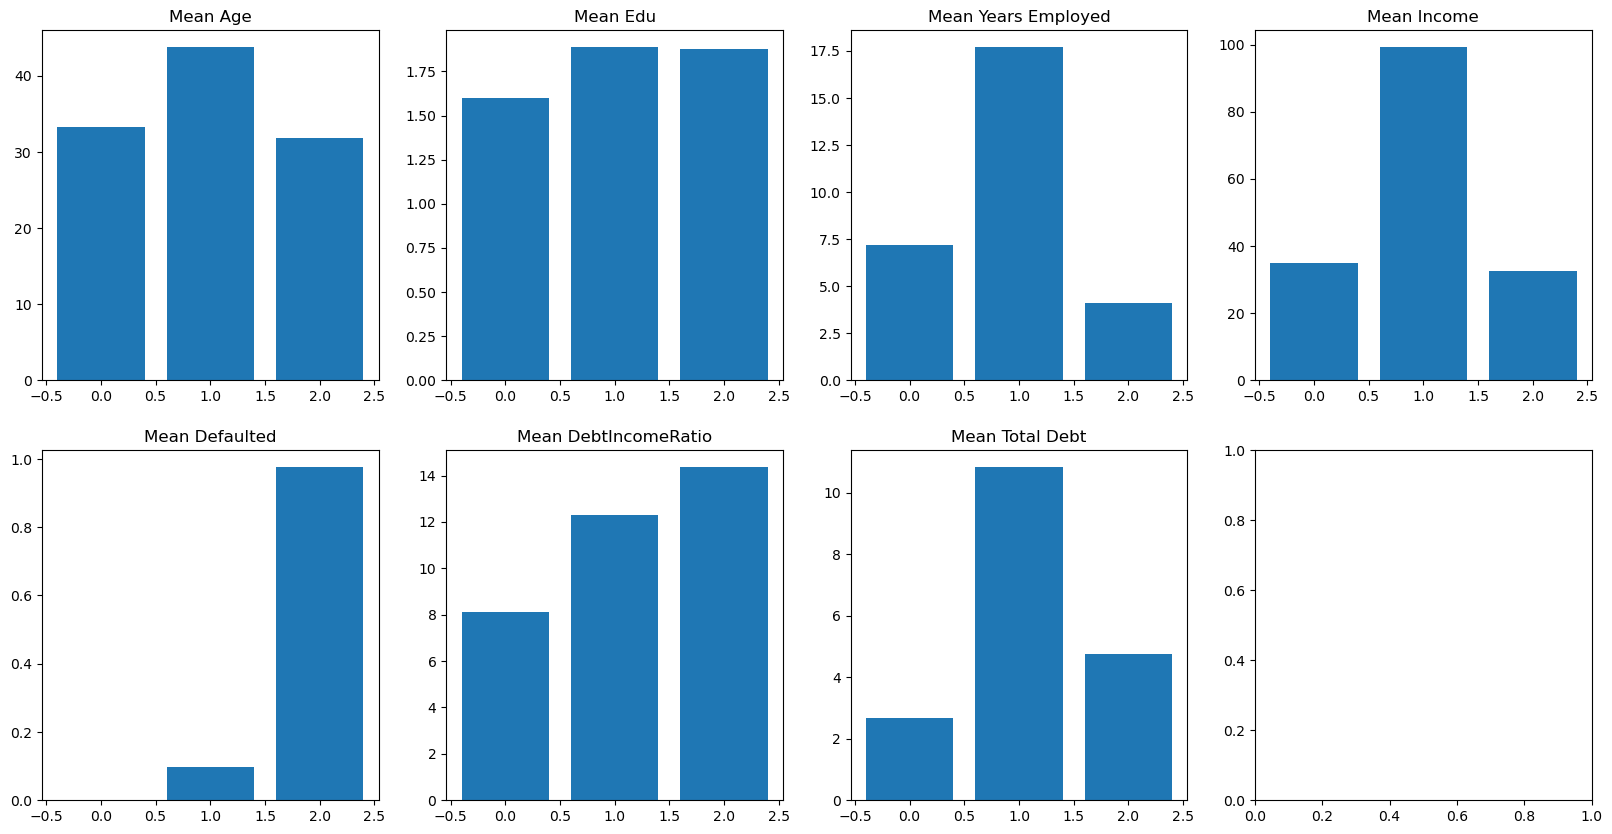

In [43]:

# Visualizing the means
fig, axes = plt.subplots(2, 4, figsize = (20, 10))
axes = axes.ravel()
#loop over columns (except 'cluster') and plot each in a separate figure
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')